## This notebooks visualizes hourly measured air pollution data from three years and compares them to monthly covid cases. The lockdown in Uusimaa during the first wave can be seen to cut down CO emissions heavily


In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import calendar 
from collections import deque
import functools
import json

In [4]:
# Conversion from unix timestamp to pandas datetime
def timestamp_to_datetime(ts):
    return pd.to_datetime(ts, unit='s')

In [8]:
dates={}
dates['2018']={"start":1519862400,"end":1545264000}
dates['2019']={"start":1551398400,"end":1576800000}
dates['2020']={"start":1583020800,"end":1608422400}

pollutants=['CO', 'NO_x', 'PM10']
target='CO'

In [6]:
data = pd.read_csv('smear-tsfixed.csv')
data['datetime']=pd.to_datetime(data['timestamp'], unit='s')
data['year']=data['datetime'].dt.year
data['month']=data['datetime'].dt.month
data['NO_2']=data['NO_x']-data['NO']

### Smooth timeseries signals by resampling to 1 hour frequency, and compute moving average for 24h to reduce the signal's noise. Also split the data into yearly sets to plot and compare them (next cell).

In [11]:

f='1H'
window=24

data2018=data[(data.timestamp>=dates['2018']['start']) & (data.timestamp<=dates['2018']['end'])]
data2019=data[(data.timestamp>=dates['2019']['start']) & (data.timestamp<=dates['2019']['end'])]
data2020=data[(data.timestamp>=dates['2020']['start']) & (data.timestamp<=dates['2020']['end'])]

data2018.index=timestamp_to_datetime(data2018.timestamp)
data2018 = data2018.resample(f).mean()
data2018 = data2018.rolling(window).mean()

data2019.index=timestamp_to_datetime(data2019.timestamp)
data2019 = data2019.resample(f).mean()
data2019 = data2019.rolling(window).mean()

data2020.index=timestamp_to_datetime(data2020.timestamp)
data2020 = data2020.resample(f).mean()
data2020 = data2020.rolling(window).mean()


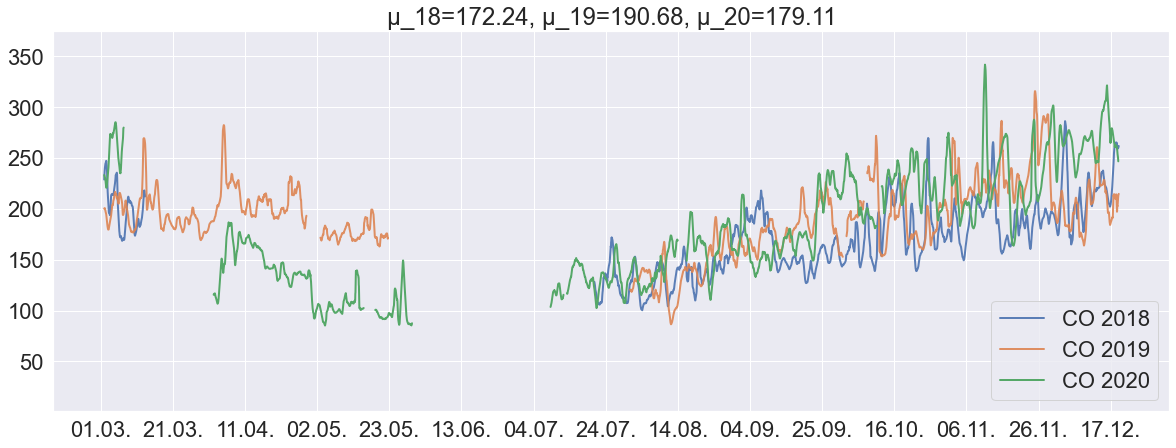

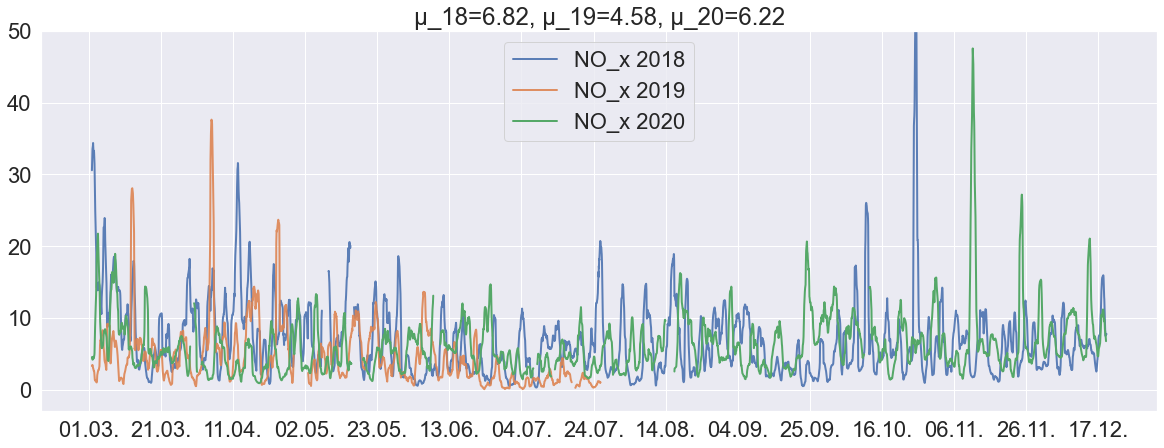

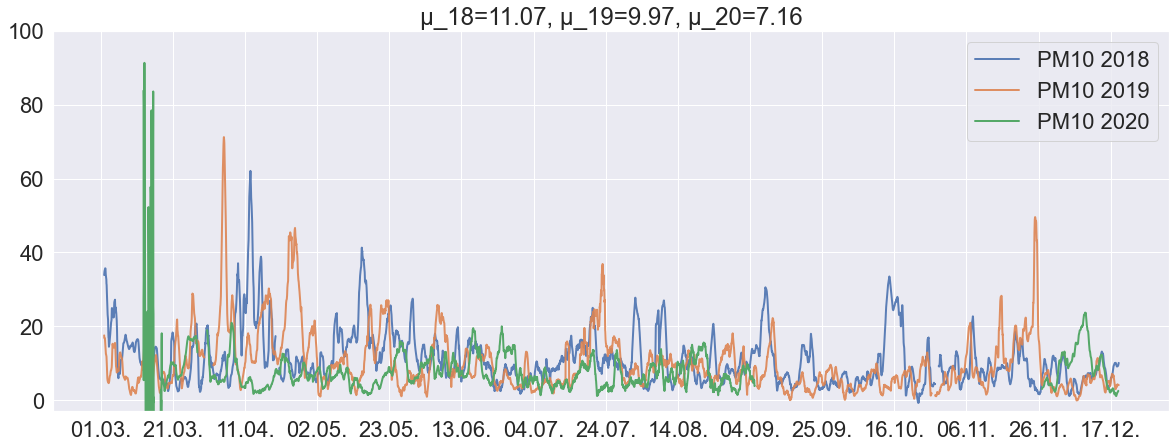

In [25]:
#### Plot configs
a, LW=0.9, 2
nth_date=500
sns.set(font_scale=2)
pd.options.display.float_format = '{:,.2f}'.format
dates_xaxis=data2019.index.strftime("%d.%m.")
y_min=[1,-3,-3]
y_max=[375, 50, 100]

for i, c in enumerate(pollutants):
    plt.figure(figsize=(20,7))
    plt.plot(range(len(data2018)), data2018[c].values, label='{} 2018'.format(c), linewidth=LW, alpha=a)
    plt.plot(range(len(data2019)),data2019[c].values, label='{} 2019'.format(c), linewidth=LW, alpha=a)
    plt.plot(range(len(data2020)),data2020[c].values, label='{} 2020'.format(c), linewidth=LW)
    plt.xticks(range(0,len(data2019), nth_date), labels=dates_xaxis[::nth_date])
    plt.title("µ_18={:,.2f}, µ_19={:,.2f}, µ_20={:,.2f}".format(data2018[c].mean(), data2019[c].mean(), data2020[c].mean()))
    plt.ylim(y_min[i],y_max[i])
    #plt.xlim(0, int(len(data2019)+0.01*len(data2019)))
    #plt.ylabel(units[i])
    plt.legend()
    #plt.savefig("{}.png".format(c))
    plt.show()


In [37]:
c = calendar.Calendar()
year=[]
k=1
for i in range(1,13):
    month=[]
    for i_weeks, weeks in enumerate(c.monthdayscalendar(2020, i)):
        if (np.array(weeks)==0).sum()<4:
            month.append(k)
            k+=1
    year.append(month)


covid_cases = pd.read_json('covid_hki_2020.json')
covid_cases = covid_cases['dataset']['value']

weekly_hki = pd.DataFrame(np.concatenate([np.array(list(covid_cases.keys())).reshape(-1,1), np.array(list(covid_cases.values())).reshape(-1,1)], axis=1), columns=['Viikko','tapauksia'])
weekly_hki['tapauksia']=weekly_hki['tapauksia'].replace('..', 0)
weekly_hki=weekly_hki.astype(int)[:-1]

month_indx = [np.isin(weekly_hki['Viikko'], m).astype(int)*(i_m+1) for i_m, m in enumerate(year)]

weekly_hki['Kuukausi']=functools.reduce(lambda a,b : a+b,month_indx)
monthly_covid_cases_helsinki = weekly_hki.drop('Viikko', axis=1).groupby('Kuukausi', as_index=False).mean().round()

monthly_covid_cases_helsinki=monthly_covid_cases_helsinki[-12:]
display(monthly_covid_cases_helsinki)



,Kuukausi,tapauksia
1,1,0.00
2,2,4.00
3,3,214.00
4,4,286.00
5,5,91.00
6,6,14.00
7,7,17.00
8,8,46.00
9,9,187.00
10,10,370.00


 ### Finally, plot number of covid cases and monthly air pollution (CO) levels separately for each year. 

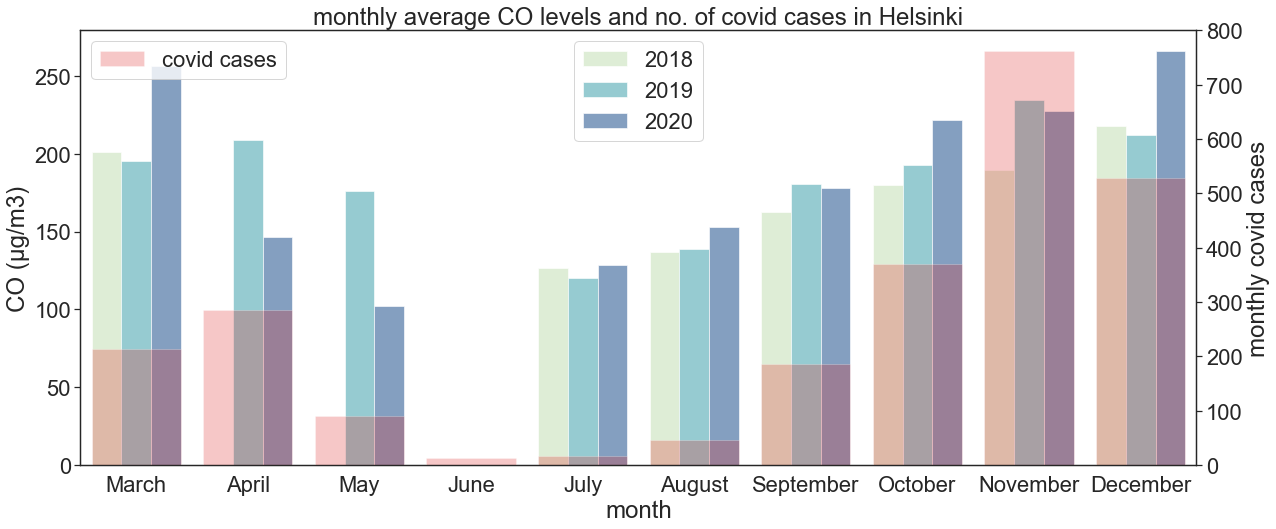

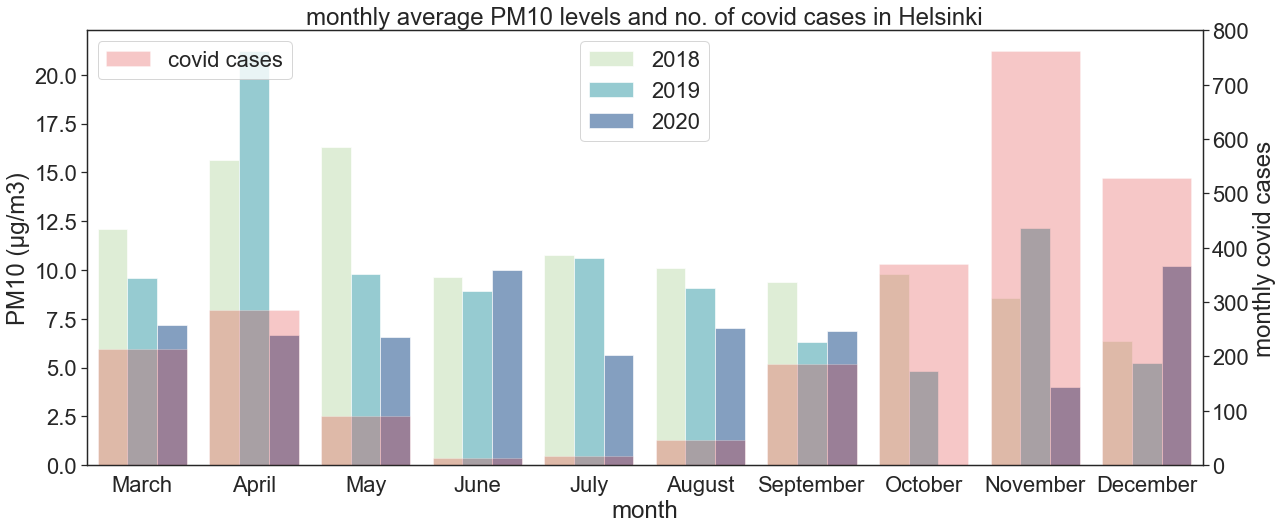

In [35]:
sns.set(font_scale=2, style='white')

for TARGET in ['CO','PM10']:
    yearly_monthly_data = data.groupby(by=['year', 'month'], as_index=False).mean().drop('timestamp', axis=1)
    low, high = 3, yearly_monthly_data[yearly_monthly_data['year']==2020]['month'].max()

    mask = (yearly_monthly_data['month'] >= low) & (yearly_monthly_data['month']<=high)

    plt.figure(figsize=(20,8))
    ax = sns.barplot(x='month', y=TARGET, hue='year', data=yearly_monthly_data[mask], palette='YlGnBu', alpha=0.6)
    ax2 = ax.twinx()
    sns.barplot(x='Kuukausi', y='tapauksia', data=monthly_covid_cases_helsinki[low-1:high], color='red', ax=ax2 ,alpha=0.25, label='covid cases')
    ax2.set_ylabel('monthly covid cases')
    ax.set_ylabel('{} (µg/m3)'.format(TARGET))

    ax.set_xticklabels(deque(calendar.month_name[low:high+1]))
    plt.xlabel('')
    ax.legend(loc='upper center')
    ax2.legend()
    plt.title("monthly average {} levels and no. of covid cases in Helsinki".format(TARGET))
    plt.show()


 ## Can we tell anything from the connection?
* Uusimaa's lockdown in March seems to have a decreasing effect as people started remote working and took isolation seriously.
* Overall very subtle changes in CO and PM10 levels from June to November.
* The increase in December's pollution levels would need more investigation. One explanation (from infinite options) might be that since 2020 December was rainy and humid, people might have preferred private cars rather than walking/cycling (bad weather) or public transportation (ongoing covid situation). Among few other sources, CO and PM10 are emitted from combustion (car engines).
